In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install torchbearer

     |████████████████████████████████| 143kB 4.0MB/s 


In [3]:
import torch
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchbearer
from torch.utils.data import DataLoader, Dataset

In [4]:
df = pd.read_csv('/content/drive/My Drive/MSc/data/data.csv')
df.columns

Index(['Attributes', 'Adj Close', 'Adj Close.1', 'Adj Close.2', 'Adj Close.3',
       'Adj Close.4', 'Close', 'Close.1', 'Close.2', 'Close.3', 'Close.4',
       'High', 'High.1', 'High.2', 'High.3', 'High.4', 'Low', 'Low.1', 'Low.2',
       'Low.3', 'Low.4', 'Open', 'Open.1', 'Open.2', 'Open.3', 'Open.4',
       'Volume', 'Volume.1', 'Volume.2', 'Volume.3', 'Volume.4'],
      dtype='object')

In [5]:
df = df.drop(['Attributes'], axis=1)

In [6]:
df = df.drop([1], axis=0)

In [7]:
col = [att + ' ' + df[att][0] for att in df.columns]
col

['Adj Close AAPL',
 'Adj Close.1 GOOGL',
 'Adj Close.2 MSFT',
 'Adj Close.3 ^IXIC',
 'Adj Close.4 ^GSPC',
 'Close AAPL',
 'Close.1 GOOGL',
 'Close.2 MSFT',
 'Close.3 ^IXIC',
 'Close.4 ^GSPC',
 'High AAPL',
 'High.1 GOOGL',
 'High.2 MSFT',
 'High.3 ^IXIC',
 'High.4 ^GSPC',
 'Low AAPL',
 'Low.1 GOOGL',
 'Low.2 MSFT',
 'Low.3 ^IXIC',
 'Low.4 ^GSPC',
 'Open AAPL',
 'Open.1 GOOGL',
 'Open.2 MSFT',
 'Open.3 ^IXIC',
 'Open.4 ^GSPC',
 'Volume AAPL',
 'Volume.1 GOOGL',
 'Volume.2 MSFT',
 'Volume.3 ^IXIC',
 'Volume.4 ^GSPC']

In [8]:
df.columns = col

In [9]:
df = df.drop([0])

In [10]:
df.columns

Index(['Adj Close AAPL', 'Adj Close.1 GOOGL', 'Adj Close.2 MSFT',
       'Adj Close.3 ^IXIC', 'Adj Close.4 ^GSPC', 'Close AAPL', 'Close.1 GOOGL',
       'Close.2 MSFT', 'Close.3 ^IXIC', 'Close.4 ^GSPC', 'High AAPL',
       'High.1 GOOGL', 'High.2 MSFT', 'High.3 ^IXIC', 'High.4 ^GSPC',
       'Low AAPL', 'Low.1 GOOGL', 'Low.2 MSFT', 'Low.3 ^IXIC', 'Low.4 ^GSPC',
       'Open AAPL', 'Open.1 GOOGL', 'Open.2 MSFT', 'Open.3 ^IXIC',
       'Open.4 ^GSPC', 'Volume AAPL', 'Volume.1 GOOGL', 'Volume.2 MSFT',
       'Volume.3 ^IXIC', 'Volume.4 ^GSPC'],
      dtype='object')

In [11]:
close_aapl = df['Close AAPL'].copy().to_numpy()

In [12]:
close_aapl_scaler = preprocessing.MinMaxScaler()
close_aapl = close_aapl_scaler.fit_transform(close_aapl.reshape(-1, 1))

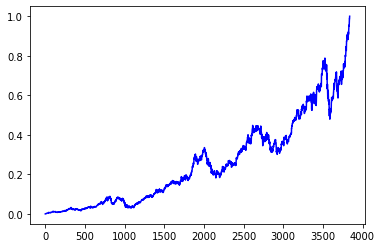

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(len(close_aapl)), close_aapl,color='blue')

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

class lstm(nn.Module) :
    def __init__(self, input_size, hidden_size, hidden1, n_layers, seq_len) :
        super(lstm, self).__init__()
        self.insize = input_size
        self.hdsize = hidden_size
        self.ousize = 1
        self.seq_len = seq_len
        self.layer = n_layers
        self.lstm_cell = nn.LSTM(input_size=self.insize,
            hidden_size=self.hdsize,num_layers=self.layer, batch_first=True)
        self.fc = nn.Linear(self.hdsize, hidden1)
        self.fc1 = nn.Linear(hidden1, 1)

    def forward(self, x) :
        self.h_state = (torch.zeros(self.layer, len(x), self.hdsize).to(device),
                        torch.zeros(self.layer, len(x), self.hdsize).to(device))
        lstm_out, self.h_state = self.lstm_cell(x, self.h_state)
        out = lstm_out.squeeze()[:,-1,:]
        out = self.fc(out)
        out = F.sigmoid(out)
        out = self.fc1(out)
        return out

In [15]:
aapl = torch.from_numpy(close_aapl)

In [16]:
def create_dataset(data_scaled, seq_length, distance) :
    xs = []
    ys = []
    for i in range(data_scaled.shape[0]-distance-seq_length-1) :
        x = data_scaled.clone()[i:i+seq_length]
        y = data_scaled.clone()[i+seq_length+distance-1]
        xs.append(x)
        ys.append(y)
    return xs, ys

In [17]:
seq_length = 50
distance = 7
xs, ys = create_dataset(aapl, seq_length, distance)
xs = torch.stack(xs)
ys = torch.stack(ys)
xs.shape, ys.shape

(torch.Size([3781, 50, 1]), torch.Size([3781, 1]))

In [18]:
train_inp = xs.clone()[:3500,:]
train_out = ys.clone()[:3500]
test_inp = xs.clone()[3500:,:]
test_out = ys.clone()[3500:]

In [19]:
train_inp = train_inp.to(device).float()
train_out = train_out.to(device).float()
test_inp = test_inp.to(device).float()
test_out = test_out.to(device).float()

In [20]:
model = lstm(1, 50, 128, 1, seq_length).to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-2)
epoch = 200

loss_function = nn.MSELoss(reduction='sum')

train_hist = torch.zeros(epoch)
test_hist = torch.zeros(epoch)

for e in range(epoch) :
    
    train_pred = model(train_inp)

    train_loss = loss_function(train_pred.float(), train_out)

    with torch.no_grad() :
        test_pred = model(test_inp) 
        test_loss = loss_function(test_pred.float(), test_out)
    
    train_hist[e] = train_loss.item()
    test_hist[e] = test_loss.item()

    if e % 10 == 0 :
        print('Train loss:', train_hist[e], '\nTest loss:', test_hist[e])

    optimiser.zero_grad()

    train_loss.backward()

    optimiser.step()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: tensor(324.4158) 
Test loss: tensor(143.7378)
Train loss: tensor(186.7797) 
Test loss: tensor(31.3222)
Train loss: tensor(99.3340) 
Test loss: tensor(32.8373)
Train loss: tensor(10.8326) 
Test loss: tensor(10.5185)
Train loss: tensor(1.9314) 
Test loss: tensor(1.9289)
Train loss: tensor(1.5615) 
Test loss: tensor(0.8440)
Train loss: tensor(0.8000) 
Test loss: tensor(0.6560)
Train loss: tensor(0.7598) 
Test loss: tensor(0.9027)
Train loss: tensor(0.6846) 
Test loss: tensor(0.8331)
Train loss: tensor(0.6563) 
Test loss: tensor(0.6999)
Train loss: tensor(0.6424) 
Test loss: tensor(0.6475)
Train loss: tensor(0.6296) 
Test loss: tensor(0.6300)
Train loss: tensor(0.6216) 
Test loss: tensor(0.6261)
Train loss: tensor(0.6149) 
Test loss: tensor(0.6104)
Train loss: tensor(0.6090) 
Test loss: tensor(0.5844)
Train loss: tensor(0.6040) 
Test loss: tensor(0.5631)
Train loss: tensor(0.5999) 
Test loss: tensor(0.5471)
Train loss: tensor(0.5965) 
Test loss: tensor(0.5330)
Train loss: tenso

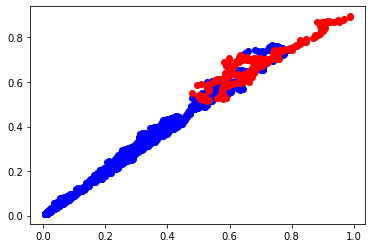

In [21]:
import matplotlib.pyplot as plt

plt.scatter(train_out.cpu().detach(), train_pred.cpu().detach(),color='blue')
plt.scatter(test_out.cpu().detach(), test_pred.cpu().detach(),color='red')

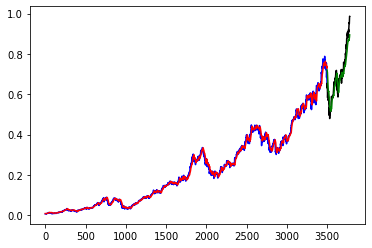

In [23]:
plt.plot(range(len(train_out)), train_out.cpu().detach(), color='blue')
plt.plot(range(len(train_pred)), train_pred.cpu().detach(), color='red')
plt.plot(range(len(train_out), len(train_out) + len(test_out)), test_out.cpu().detach(), color='black')
plt.plot(range(len(train_out), len(train_out) + len(test_out)), test_pred.cpu().detach(), color='green')

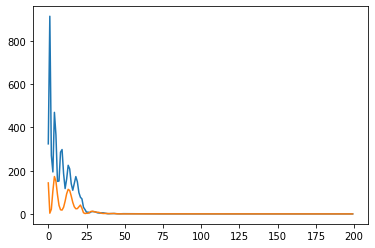

In [24]:
plt.plot(range(epoch),train_hist)
plt.plot(range(epoch),test_hist)

In [25]:
df.to_csv('/content/drive/My Drive/MSc/data/data.csv')